# Libs and data

In [1]:
using Flux
using Plots
using DataFrames
using CSV
using Flux: params
using Flux: train!
using JLD
using DifferentialEquations

In [2]:
train_x = load("train_x.jld")["data"]'
train_y = load("train_y.jld")["data"]'
val_x = load("val_x.jld")["data"]'
val_y = load("val_y.jld")["data"]'
test_x = load("test_x.jld")["data"]'
test_y = load("test_y.jld")["data"]'
# const global real_data = load("data.jld")["data"]'
real_data = load("data.jld")["data"]'
print("Size of train_x:" , size(train_x) , "\n")
print("Size of train_y:" , size(train_y) , "\n")
print("Size of val_x:" , size(val_x) , "\n")
print("Size of val_y:" , size(val_y) , "\n")
print("Size of test_x:" , size(test_x) , "\n")
print("Size of test_y:" , size(test_y) , "\n")
# print("Size of real data:" , size(real_data) , "\n")

Size of train_x:(1, 24)
Size of train_y:(1, 24)
Size of val_x:(1, 6)
Size of val_y:(1, 6)
Size of test_x:(1, 71)
Size of test_y:(1, 71)


# Construct the model

In [37]:

model  = Chain(
    Dense(1,64,tanh),
    Dense(64,64,gelu),
#     Dense(32,32,gelu),#leakyrelu
    Dense(64,1,tanh)
)

train_set = [(train_x ,train_y)]
# data = [(x_train ,y_train)]
learning_rate = 0.00075


0.00075

# Construct loss fuction

The loss function contains 2 parts: $LOSS_{NN}$ and $LOSS_{ODE}$

In [4]:
const global k = 300
const global c = 5

5

In [5]:
function loss_PINN_1(x,y)
    
    loss_NN = Flux.mse(model(x),y) # Get the loss of the neural network part
    
    # calculate the loss of ODE
    x_1 = [i for i = 0:0.01:1]
    
    n = length(x_1)
    NN = [model([a])[1] for a in x_1] # the output of the model

    dt = 1/(n-1)
    
    NN_p = diff(NN) / dt
    NN_pp = diff(NN_p) / dt 
    
    # Because of the dims differences(using diff to a (5,1) vector will return a (4,1) vector), we need to make their's dims the same.
    # I just simply cut the front and back side of the data.
    NN_1 = [NN[i] for i in firstindex(NN)+1:lastindex(NN)-1]
    NN_1p = [NN_p[i] for i in firstindex(NN_p):lastindex(NN_p)-1]
    
    loss_ODE = sum(abs2 , 300 * NN_1 + 5 * NN_1p + NN_pp )
    
#     print(loss_ODE , "\n")
    
    loss = 0.000001 * loss_ODE + loss_NN
    
    return loss
    
end

loss_PINN_1 (generic function with 1 method)

In [6]:
loss_MSE(x,y) = Flux.mse(model(x),y)

loss_MSE (generic function with 1 method)

# Train

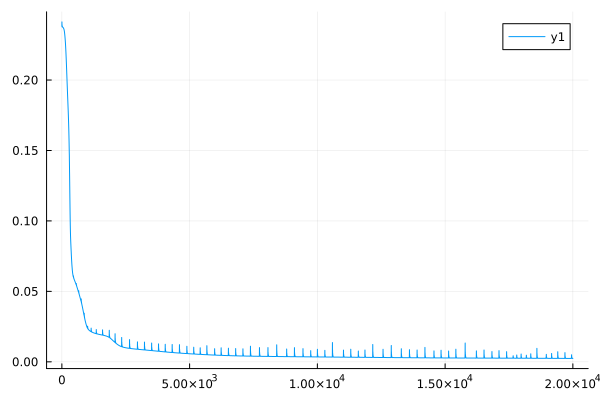

In [39]:
opt = ADAM(learning_rate)
# opt = Flux.Descent(0.005)
epochs = 20000 # 20000 will get a very good result, but slow
# train_loss = Array{Float32}(undef, epochs)
train_loss = zeros(epochs)

for i in 1:epochs
    
    train!(loss_PINN_1,params(model), train_set, opt)
    train_loss[i] = loss_PINN_1(train_x,train_y)
    
#     train!(loss_MSE,params(model), train_set, opt)
#     train_loss[i] = loss_MSE(train_x,train_y)
    
    # Here the comment is using MSE loss fuction and compare the value's, don't should let the magnitude of loss_ode and loss_MSE become so different
    
end

plot(train_loss) 

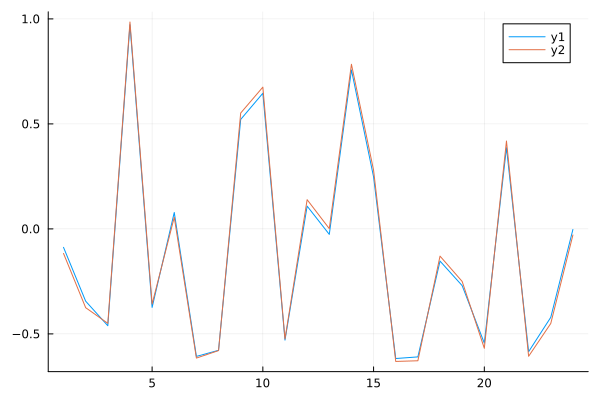

In [40]:
test_y_pre = model(train_x)
plot([test_y_pre' , train_y'])

0.042789190384171484

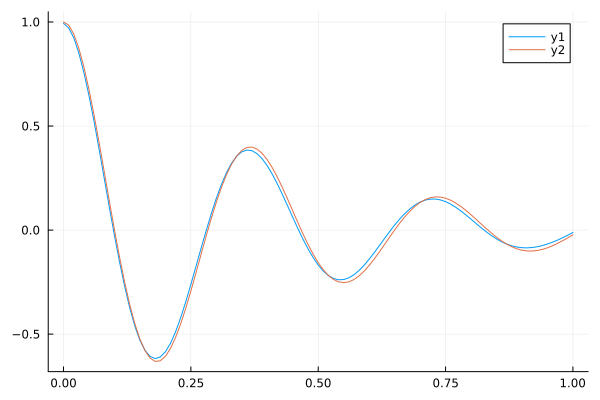

In [41]:
# 1-64-64-1 gelu 20000
x_t = [i for i = 0:0.01:1]

NN = [model([a])[1] for a in x_t] # the output of the model

diffrence = [NN[i] - real_data'[i] for i in firstindex(NN):lastindex(NN)]

print(sum(abs2 , diffrence))

plot(x_t , [NN, real_data'])

0.01814920048229316

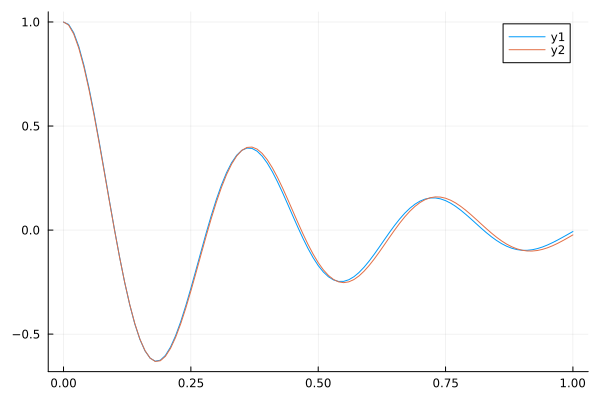

In [36]:
# 1-32-32-32-1 gelu gelu 20000
x_t = [i for i = 0:0.01:1]

NN = [model([a])[1] for a in x_t] # the output of the model

diffrence = [NN[i] - real_data'[i] for i in firstindex(NN):lastindex(NN)]

print(sum(abs2 , diffrence))

plot(x_t , [NN, real_data'])

0.018774015080130383

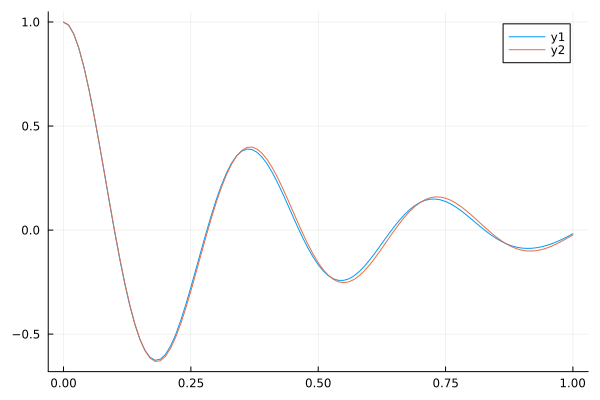

In [25]:
x_t = [i for i = 0:0.01:1]

NN = [model([a])[1] for a in x_t] # the output of the model

diffrence = [NN[i] - real_data'[i] for i in firstindex(NN):lastindex(NN)]

print(sum(abs2 , diffrence))

plot(x_t , [NN, real_data'])